# Advannced Lane Detection Project

The goals / steps of this project are the following:
  * Use color transforms, gradients, etc., to create a thresholded binary image.
  * Apply a perspective transform to rectify binary image ("birds-eye view").
  * Detect lane pixels and fit to find the lane boundary.
  * Determine the curvature of the lane and vehicle position with respect to center.
  * Warp the detected lane boundaries back onto the original image.
  * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Libraries

In [1]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time

In [2]:
def threshold_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert the image to HLS color space and separate the L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Apply Sobel x on the L channel for gradient threshold
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Sobel x
    abs_sobelx = np.absolute(sobelx)  # Absolute value of gradients
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))  # Scale to 8-bit
    
    # Threshold on the Sobel gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold on the S channel (color threshold)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    return combined_binary

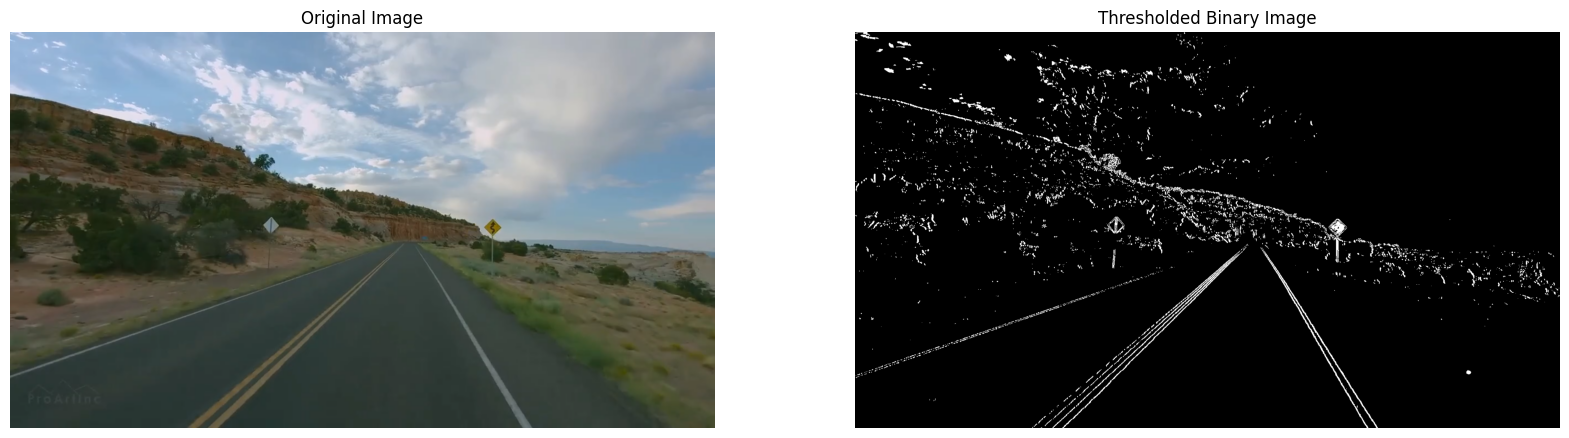

In [3]:
# Load the image
image = cv2.imread("test_images/scene5.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Apply thresholding
binary_output = threshold_binary(image)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(binary_output, cmap="gray")
ax[1].set_title("Thresholded Binary Image")
ax[1].axis("off")

plt.show()

## Transforming image from 2D to Birds Eye View

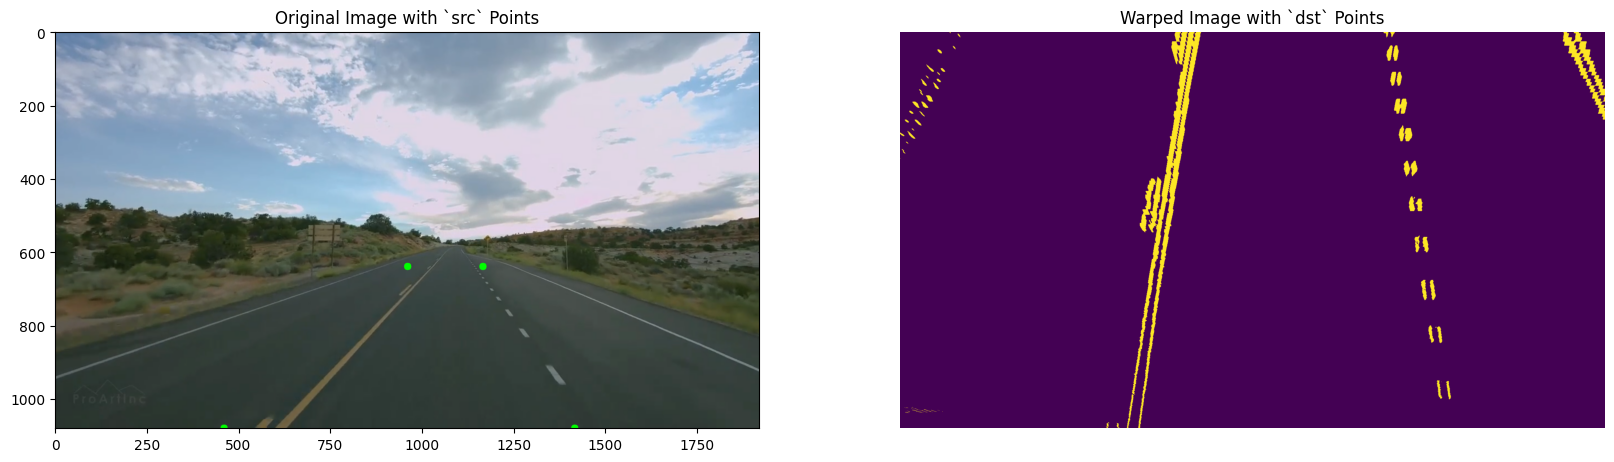

In [4]:
# transform the image to a top-down view
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    # Define the 4 source points
    src = np.float32(
        [[(img_size[0] // 2)  , img_size[1]//2 + 100], # top-left
         [((img_size[0] // 4) - 20), img_size[1]], # bottom-left
         [(img_size[0] * 3 // 4) - 25, img_size[1]], # bottom-right
         [(img_size[0] // 2 + 205),  img_size[1]//2 + 100]]) # top-right
    
    # Define the 4 destination points
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv, src, dst

# Load the image
image = cv2.imread("test_images/scene2.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Apply thresholding
binary_output = threshold_binary(image)

# Apply perspective transform
warped, M, Minv, src, dst = perspective_transform(binary_output)

# Draw `src` points on the original image
image_with_src = image_rgb.copy()
for point in src:
    cv2.circle(image_with_src, tuple(point.astype(int)), 10, (0, 255, 0), -1)

# Draw `dst` points on the warped image
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
# for point in dst:
#     cv2.circle(warped_rgb, tuple(point.astype(int)), 10, (255, 0, 0), -1)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Original image with `src` points
ax[0].imshow(image_with_src)
ax[0].set_title("Original Image with `src` Points")
# ax[0].axis("off")

# Warped image with `dst` points
ax[1].imshow(warped)
ax[1].set_title("Warped Image with `dst` Points")
ax[1].axis("off")

plt.show()


## Detecting Lane Lines pixels by applying sliding window

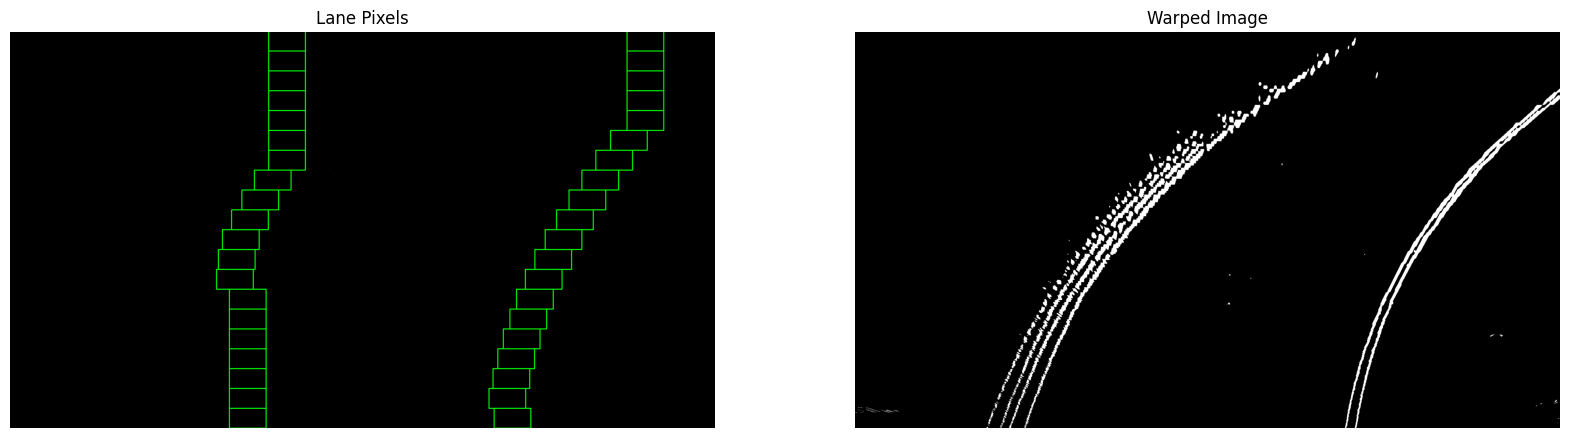

In [5]:
# find the lane lines
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                           
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# Load the image
image = cv2.imread("test_images/scene4.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Apply thresholding
binary_output = threshold_binary(image)

# Apply perspective transform
warped, M, Minv, src, dst = perspective_transform(binary_output)

# Find lane pixels
leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Original image with `src` points
ax[0].imshow(out_img)
ax[0].set_title("Lane Pixels")
ax[0].axis("off")

# Warped image with `dst` points
ax[1].imshow(warped, cmap="gray")
ax[1].set_title("Warped Image")
ax[1].axis("off")

plt.show()

## Determining the curvature of the lane and vehicle position with respect to center

(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

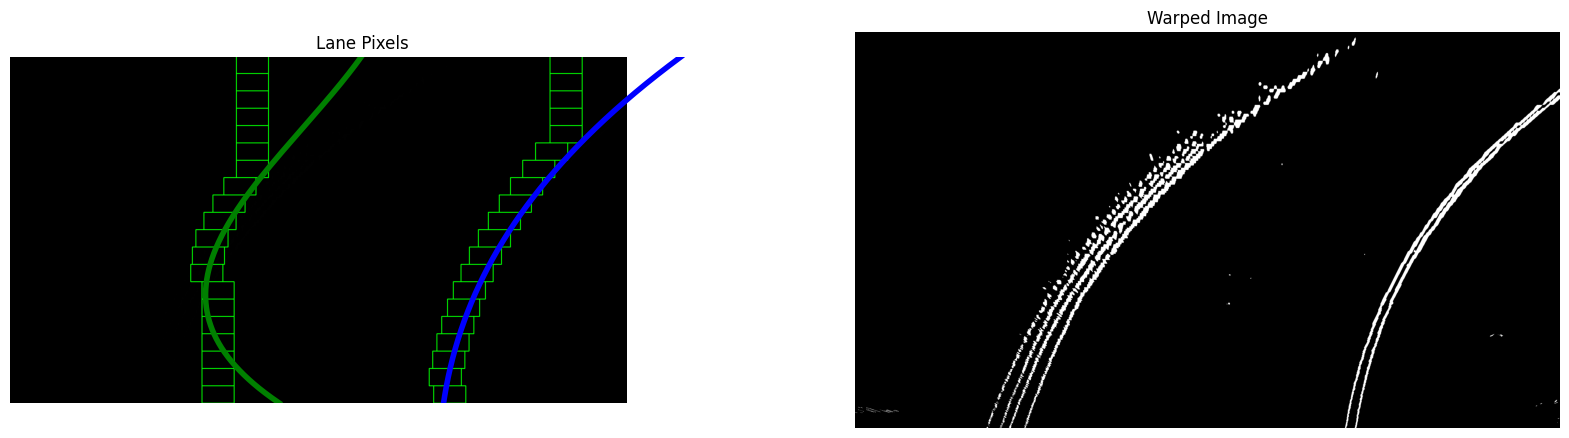

In [6]:
# determing the lane lines by fitting a polynomial
def fit_polynomial(binary_warped):
    # Find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a third order polynomial
    left_fit = np.polyfit(lefty, leftx, 3)
    right_fit = np.polyfit(righty, rightx, 3)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = (left_fit[0] * ploty**3 +
                     left_fit[1] * ploty**2 +
                     left_fit[2] * ploty +
                     left_fit[3])
        right_fitx = (right_fit[0] * ploty**3 +
                      right_fit[1] * ploty**2 +
                      right_fit[2] * ploty +
                      right_fit[3])
    except TypeError:
        print("The function failed to fit a line!")
        left_fitx = ploty**3 + ploty**2 + ploty
        right_fitx = ploty**3 + ploty**2 + ploty
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img

# Load the image
image = cv2.imread("test_images/scene4.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Apply thresholding
binary_output = threshold_binary(image)

# Apply perspective transform
warped, M, Minv, src, dst = perspective_transform(binary_output)

# Fit polynomial
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(warped)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Original image with `src` points
ax[0].imshow(out_img)
ax[0].plot(left_fitx, ploty, color="green", linewidth=4)
ax[0].plot(right_fitx, ploty, color="blue", linewidth=4)
ax[0].set_title("Lane Pixels")
ax[0].axis("off")

# Warped image with `dst` points
ax[1].imshow(warped, cmap="gray")
ax[1].set_title("Warped Image")
ax[1].axis("off")


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

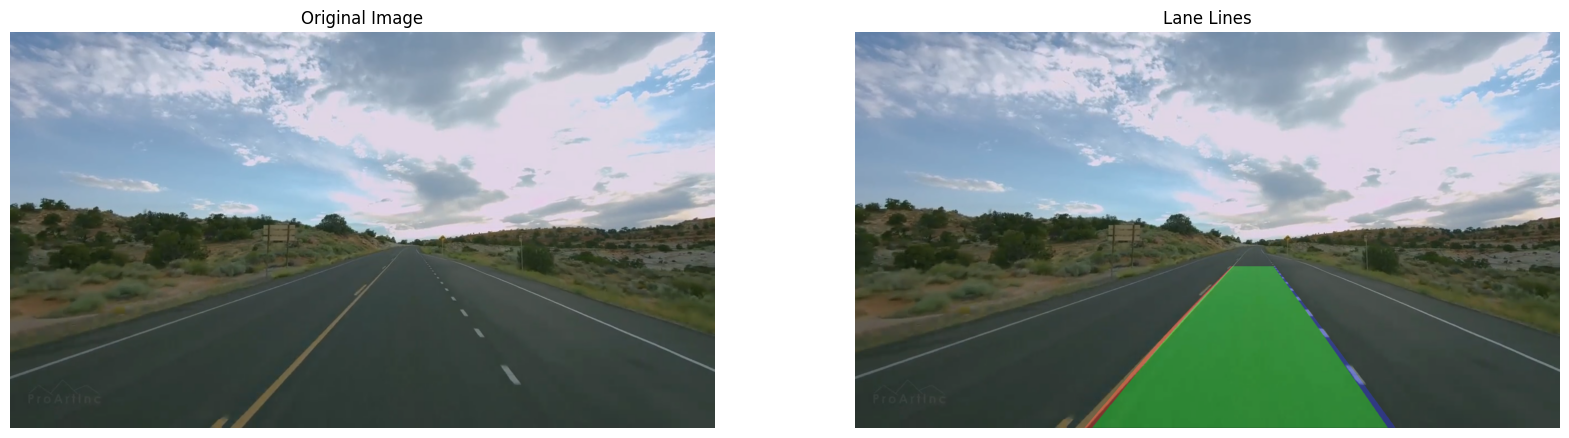

In [7]:
## warp the detected lane lines back to the original image
def draw_lane_lines(image, binary_warped, left_fit, right_fit, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = (left_fit[0] * ploty**3 +
                 left_fit[1] * ploty**2 +
                 left_fit[2] * ploty +
                 left_fit[3])
    right_fitx = (right_fit[0] * ploty**3 +
                  right_fit[1] * ploty**2 +
                  right_fit[2] * ploty +
                  right_fit[3])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # add the lane lines to the original image
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 0, 255), thickness=20)

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

# Load the image
image = cv2.imread("test_images/scene2.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Apply thresholding
binary_output = threshold_binary(image)

# Apply perspective transform
warped, M, Minv, src, dst = perspective_transform(binary_output)

# Fit polynomial
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(warped)

# Draw lane lines
result = draw_lane_lines(image_rgb, warped, left_fit, right_fit, Minv)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Original image with `src` points
ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Warped image with `dst` points
ax[1].imshow(result)
ax[1].set_title("Lane Lines")
ax[1].axis("off")


## calculate the radius of curvature of the fit.

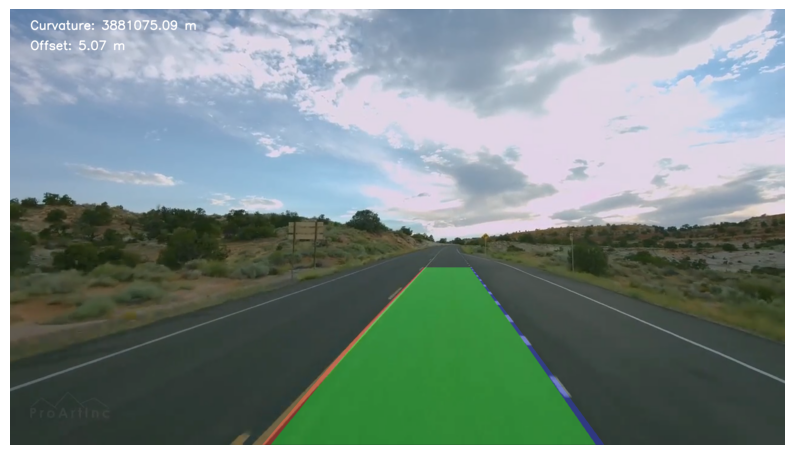

In [8]:
# curvature and offset
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (3 * left_fit[0] * y_eval * ym_per_pix + 2 * left_fit[1])**2)**1.5) / np.absolute(6 * left_fit[0])
    right_curverad = ((1 + (3 * right_fit[0] * y_eval * ym_per_pix + 2 * right_fit[1])**2)**1.5) / np.absolute(6 * right_fit[0])
    
    return left_curverad, right_curverad

def measure_offset(image, left_fit, right_fit):
    '''
    Calculates the offset of the vehicle from the center of the lane in meters.
    '''
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    image_center = image.shape[1] / 2  # center of the image
    
    # Calculate the center of the lane
    left_lane = left_fit[0] * image.shape[0]**2 + left_fit[1] * image.shape[0] + left_fit[2]
    right_lane = right_fit[0] * image.shape[0]**2 + right_fit[1] * image.shape[0] + right_fit[2]
    lane_center = (left_lane + right_lane) / 2
    
    # Calculate the offset of the vehicle
    offset = (image_center - lane_center) * xm_per_pix
    
    return offset

# Load the image
image = cv2.imread("test_images/scene2.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert

# Apply thresholding
binary_output = threshold_binary(image)

# Apply perspective transform
warped, M, Minv, src, dst = perspective_transform(binary_output)

# Fit polynomial
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(warped)

# Draw lane lines
result = draw_lane_lines(image_rgb, warped, left_fit, right_fit, Minv)

# Measure curvature
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
curvature = (left_curverad + right_curverad) / 2

# Measure offset
offset = measure_offset(image, left_fit, right_fit)

# Annotate the curvature and offset on the image
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, f"Curvature: {curvature:.2f} m", (50, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(result, f"Offset: {offset:.2f} m", (50, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(result)

plt.axis("off")

plt.show()


## Loop through the video frames and apply the pipeline

In [28]:
video_path = "sample_videos\Autonomous driving lane detection sample video 1.mp4"

# Load the video
cap = cv2.VideoCapture(video_path)

# Get the video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    start_time = time.time()
    # Apply thresholding
    binary_output = threshold_binary(frame)
    
    # Apply perspective transform
    warped, M, Minv, src, dst = perspective_transform(binary_output)
    
    # Fit polynomial
    left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(warped)
    
    # Draw lane lines
    result = draw_lane_lines(frame, warped, left_fit, right_fit, Minv)

    # Measure curvature
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
    curvature = (left_curverad + right_curverad) / 2

    # Annotate the curvature and offset on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, f"Curvature: {curvature:.2f} m", (450, 50), font, 1, (100, 0, 100), 2, cv2.LINE_AA)
    
    
    # Prepare binary and warped overlays
    overlay_size = (200, 120)  # Mini-frame size (width, height)
    binary_mini = cv2.resize((binary_output * 255).astype(np.uint8), overlay_size)
    warped_mini = cv2.resize(warped, overlay_size)

    # Convert to RGB for overlaying
    binary_mini_color = cv2.cvtColor(binary_mini, cv2.COLOR_GRAY2BGR)
    warped_mini_color = cv2.cvtColor((warped_mini * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Place the binary and warped mini-frames on the result
    result[10:10 + overlay_size[1], 10:10 + overlay_size[0]] = binary_mini_color
    result[10:10 + overlay_size[1], 20 + overlay_size[0]:20 + 2 * overlay_size[0]] = warped_mini_color

    # Annotate mini-frame labels
    cv2.putText(result, "Binary Output", (15, 10 + overlay_size[1] + 20), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(result, "Warped Image", (15 + overlay_size[0] + 10, 10 + overlay_size[1] + 20), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    end_time = time.time()
    # Calculate the frame rate
    frame_rate = 1 / (end_time - start_time)
    # Annotate the frame rate on the image
    cv2.putText(result, f"Frame Rate: {frame_rate:.2f} fps", (450, 100), font, 1, (0, 105,20), 2, cv2.LINE_AA)

    # Display the result
    cv2.imshow("Lane Lines", result)
    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()